In [1]:
%load_ext autoreload

In [7]:
%autoreload 2
from collections import defaultdict
from datetime import datetime
import h5py
import matplotlib.pyplot as plt
from neural_analysis.matIO import loadmat
import numpy as np
import os
import pandas as pd
import re
from scipy.signal import butter, filtfilt, freqz
import sys
import time
from tqdm.auto import tqdm

sys.path.append('../../..')
from ld_utils import compute_eigs, get_data_sigma_norms
from up_down import get_up_down
from utils import get_data_class, get_result_path, load, save

In [3]:
session = 'Mary-Anesthesia-20160809-01'
# session = 'Mary-Anesthesia-20170203-02'

## Load Neural Data

In [9]:
all_data_dir = "/om/user/eisenaj/datasets/anesthesia/mat"
data_class = get_data_class(all_data_dir, session)

ValueError: Neural data for session Mary-Anesthesia-20160809-01 could not be found in the provided folder.

In [5]:
filename = os.path.join(all_data_dir, data_class, f'{session}.mat')
print("Loading data ...")
start = time.process_time()
electrode_info, lfp_schema, session_info, spike_times, unit_info = loadmat(filename, variables=['electrodeInfo', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'unitInfo'], verbose=False)
spike_times = spike_times[0]
dt = lfp_schema['smpInterval'][0]
# T = lfp.shape[0]

print(f"Data loaded (took {time.process_time() - start:.2f} seconds)")

NameError: name 'data_class' is not defined

## Load Results

In [11]:
data_class = 'propofolPuffTone'

In [12]:
VAR_all_results_dir = f"/om/user/eisenaj/ChaoticConsciousness/results/{data_class}/VAR"
window = 2.5
stride = 2.5
VAR_results_dir = get_result_path(VAR_all_results_dir, session, window, stride)

In [14]:
VAR_results_dir

'/om/user/eisenaj/ChaoticConsciousness/results/propofolPuffTone/VAR/VAR_Mary-Anesthesia-20160809-01_window_2.5_stride_2.5_Feb-03-2022_1546'

In [13]:
VAR_results = {}
for file in tqdm(os.listdir(VAR_results_dir)):
    if file == 'all':
        VAR_results[file] = load(os.path.join(VAR_results_dir, file))        

  0%|          | 0/5 [00:00<?, ?it/s]

IsADirectoryError: [Errno 21] Is a directory: '/om/user/eisenaj/ChaoticConsciousness/results/propofolPuffTone/VAR/VAR_Mary-Anesthesia-20160809-01_window_2.5_stride_2.5_Feb-03-2022_1546/all'

In [70]:
VAR = VAR_results['all']

## Compute Matrix Norms

In [71]:
areas = np.unique(electrode_info['area'])

In [72]:
matrix_norms = {}
iterator = tqdm(total = len(areas)*len(areas))
for area1 in areas:
    for area2 in areas:
#         print(f"{area1} --> {area2}")
        matrix_norms[(area1, area2)] = np.zeros(len(VAR))
        area1_inds = np.where(electrode_info['area'] == area1)[0]
        area2_inds = np.where(electrode_info['area'] == area2)[0]
        
        for i in range(len(VAR)):
            A_mat = VAR.A_mat.iloc[i]
            matrix_norms[(area1, area2)][i] = np.linalg.norm(A_mat[area1_inds, :][:, area2_inds], ord=2)
    
        iterator.update()
iterator.close()

  0%|          | 0/16 [00:00<?, ?it/s]

## Plot

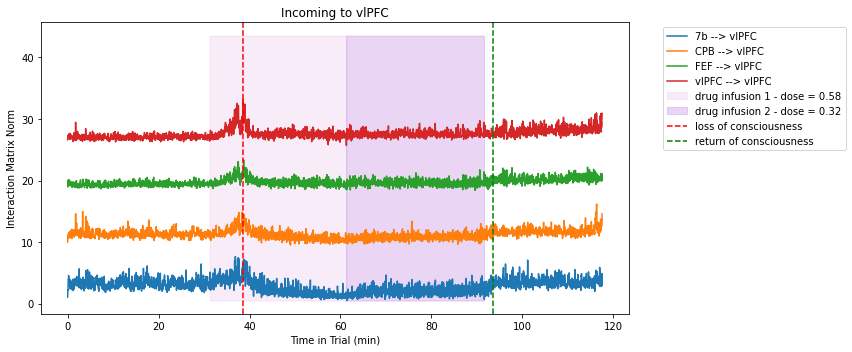

In [74]:
rows = 1
cols = 1

fig, axs = plt.subplots(rows, cols, figsize=(12, 5))

t = np.arange(len(VAR))*stride/60
for i, area2 in enumerate(areas):
    if area2 == 'vlPFC':
        if cols > 1 and rows > 1:
            ax = axs[int(i/1)][i % 1]
        elif cols == 1 and rows == 1:
            ax = axs
        else:
            ax = axs[i]
        ax.set_title(f"Incoming to {area2}")
        ax.set_xlabel('Time in Trial (min)')
        ax.set_ylabel('Interaction Matrix Norm')
        min_val = np.Inf
        max_val = -np.Inf
        
        offset = 0
        for area1 in areas:
            norms = matrix_norms[(area1, area2)]
            ax.plot(t, norms + offset, label=f"{area1} --> {area2}")
            offset += norms.max()*1.15
            if norms.min() < min_val:
                min_val = norms.min()
            if norms.max() + offset > max_val:
                max_val = norms.max() + offset


        ax.fill_between(np.arange(session_info['drugStart'][0], session_info['drugEnd'][0], stride)/60, 
                                        min_val, max_val, color='plum', alpha=0.2, label=f"drug infusion 1 - dose = {session_info['drugDose'][0]}")
        ax.fill_between(np.arange(session_info['drugStart'][1], session_info['drugEnd'][1], stride)/60, 
                                min_val, max_val, color='darkorchid', alpha=0.2, label=f"drug infusion 2 - dose = {session_info['drugDose'][1]}")

        ax.axvline(session_info['eyesClose'][-1]/60 if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']/60, linestyle='--', c='red', label="loss of consciousness")
        ax.axvline(session_info['eyesOpen'][-1]/60 if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']/60, linestyle='--', c='green', label="return of consciousness")
plt.legend(bbox_to_anchor=(1.05,1))  
plt.tight_layout()